In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt

from lob_data_utils import roc_results
from lob_data_utils import lob
from lob_data_utils import db_result

data_length = 5050

## Data preparation

In [2]:
results = db_result.get_svm_results_for_data_length(data_length, 'test')
result_cv = db_result.get_svm_results_for_data_length(data_length, 'cv')

df_cv = pd.DataFrame(result_cv)

In [3]:
df_cv.drop('algorithm_id', axis=1, inplace=True)
df_cv.drop('svm_id', axis=1, inplace=True)
df_cv.drop('name', axis=1, inplace=True)
df_cv.drop('id', axis=1, inplace=True)
df_cv.drop('data_length', axis=1, inplace=True)
df_cv.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock
0,0.0005,0.0,cv,0.005,rbf,0.5,10166
1,0.0005,0.0,cv,0.500,rbf,0.5,10166
2,0.0005,0.0,cv,5.000,rbf,0.5,10166
3,0.0005,0.0,cv,50.000,rbf,0.5,10166
4,0.0005,0.0,cv,500.000,rbf,0.5,10166


In [4]:
bests = []
df_best_agg = df_cv.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df_cv.loc[df_best_agg]
df_bests.index = df_bests['stock']

test_roc_auc_scores = []
for i, row in df_bests.iterrows():
    res = db_result.get_svm_results_by_params(
            row['stock'], row['kernel'], data_type='test', data_length=data_length, 
            gamma=row['gamma'], c=row['c'], coef0=row['coef0'])
    test_roc_auc_scores.append(res[0].get('roc_auc_score'))

df_bests['test_roc_auc_score'] = test_roc_auc_scores 
df_bests.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score
stock,,,,,,,,
10166,0.500,0.5,cv,5000.0000,sigmoid,0.572526,10166,0.555971
10470,5.000,0.0,cv,0.5000,rbf,0.622024,10470,0.545011
10484,0.001,10.0,cv,0.0001,sigmoid,0.575059,10484,0.539791
10508,100.000,0.0,cv,10.0000,rbf,0.586053,10508,0.584078
10795,0.005,0.5,cv,5.0000,sigmoid,0.635927,10795,0.624902


In [5]:
log_res = []
for i, row in df_bests.iterrows():
    log_res.append(roc_results.result_test_5050.get(row['stock']))
df_bests['test_log_roc_auc_score'] = log_res
df_bests['diff'] = df_bests['test_roc_auc_score'] - log_res
df_bests.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
stock,,,,,,,,,,
10166,0.500,0.5,cv,5000.0000,sigmoid,0.572526,10166,0.555971,0.551324,0.004647
10470,5.000,0.0,cv,0.5000,rbf,0.622024,10470,0.545011,0.548974,-0.003963
10484,0.001,10.0,cv,0.0001,sigmoid,0.575059,10484,0.539791,0.540639,-0.000847
10508,100.000,0.0,cv,10.0000,rbf,0.586053,10508,0.584078,0.579588,0.004490
10795,0.005,0.5,cv,5.0000,sigmoid,0.635927,10795,0.624902,0.625863,-0.000961


## SVM vs null hyposthesis for test set

Testing - min:  0.520965926693 max: 0.631113938366
Validation - min:  0.542120424918 max: 0.641330875735


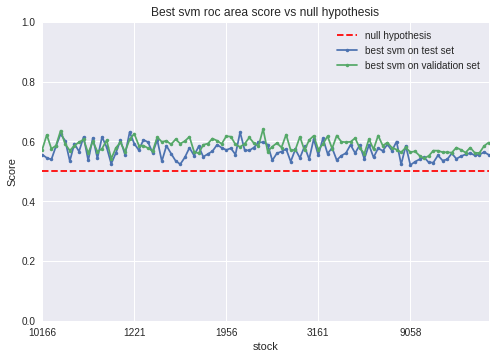

In [6]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['test_roc_auc_score'].plot(marker='.', label='best svm on test set')
df_bests['roc_auc_score'].plot(marker='.', label='best svm on validation set')
print('Testing - min: ', df_bests['test_roc_auc_score'].min(), 'max:',  df_bests['test_roc_auc_score'].max())
print('Validation - min: ', df_bests['roc_auc_score'].min(), 'max:',  df_bests['roc_auc_score'].max())
plt.ylabel('Score')
plt.legend()
plt.ylim(0, 1)
plt.title('Best svm roc area score vs null hypothesis')

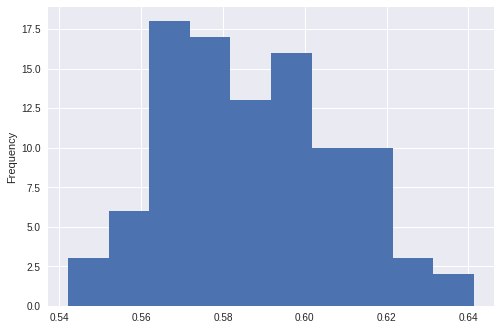

In [7]:
df_bests['roc_auc_score'].plot('hist')

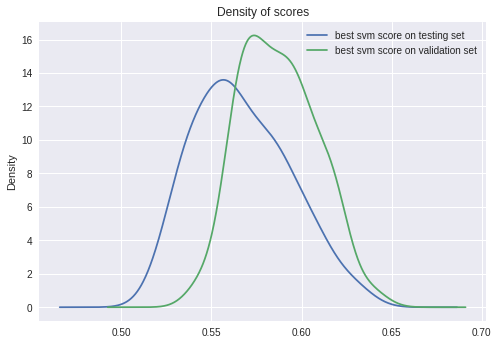

In [8]:
df_bests['test_roc_auc_score'].plot('kde', label='best svm score on testing set')
df_bests['roc_auc_score'].plot('kde', label='best svm score on validation set')
plt.title('Density of scores')
plt.legend()

## SVM vs logistic regression

In [9]:
print('Number of better SVMs:', 
      len(df_bests[df_bests['test_log_roc_auc_score'] < df_bests['test_roc_auc_score']]['stock'].unique()), 
      'per', len(df_bests['stock'].unique()))

Number of better SVMs: 40 per 98


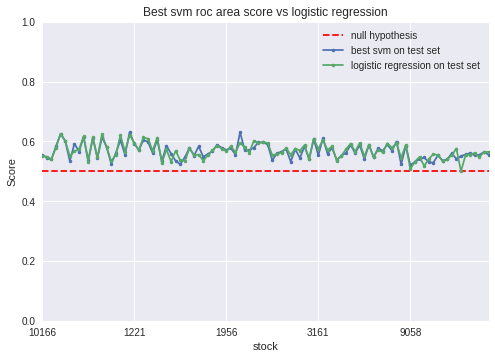

In [10]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['test_roc_auc_score'].plot(marker='.', label='best svm on test set')
df_bests['test_log_roc_auc_score'].plot(marker='.', label='logistic regression on test set')

plt.ylabel('Score')
plt.legend()
plt.ylim(0, 1)
plt.title('Best svm roc area score vs logistic regression')

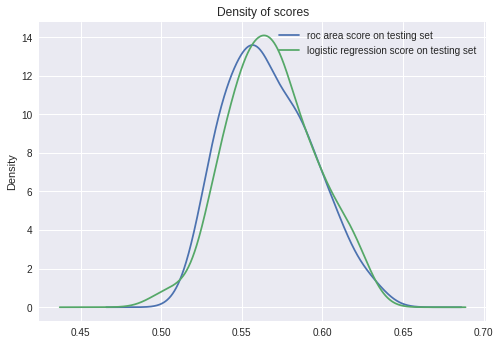

In [11]:
df_bests['test_roc_auc_score'].plot('kde', label='roc area score on testing set')
df_bests['test_log_roc_auc_score'].plot('kde', label='logistic regression score on testing set')
plt.title('Density of scores')
plt.legend()

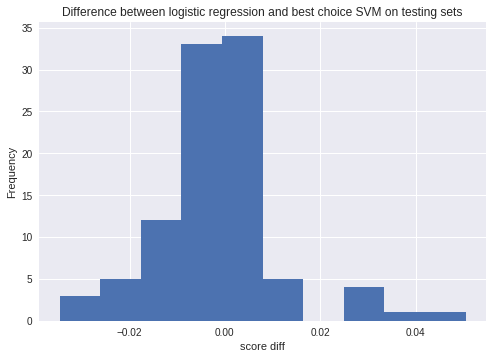

In [12]:
df_bests['diff'].plot(kind='hist')
plt.title('Difference between logistic regression and best choice SVM on testing sets')
plt.xlabel('score diff')

## Let's check the other best kernels

In [13]:
df_best_agg = df_cv.groupby(['stock', 'kernel'], as_index=False)['roc_auc_score'].idxmax()
df_bests_by_kernels = df_cv.loc[df_best_agg]

test_roc_auc_scores = []
for i, row in df_bests_by_kernels.iterrows():
    res = db_result.get_svm_results_by_params(
            row['stock'], row['kernel'], data_type='test', data_length=data_length, 
            gamma=row['gamma'], c=row['c'], coef0=row['coef0'])
    test_roc_auc_scores.append(res[0].get('roc_auc_score'))

df_bests_by_kernels['test_roc_auc_score'] = test_roc_auc_scores 

df_bests_by_kernels.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score
15,0.500,0.0,cv,-1.0,linear,0.547635,10166,0.553943
36446,100.000,0.0,cv,1.0,rbf,0.559713,10166,0.551204
3634,0.500,0.5,cv,5000.0,sigmoid,0.572526,10166,0.555971
21855,0.005,0.0,cv,-1.0,linear,0.621270,10470,0.541373
21865,5.000,0.0,cv,0.5,rbf,0.622024,10470,0.545011


In [14]:
log_res = []
for i, row in df_bests_by_kernels.iterrows():
    log_res.append(roc_results.result_test_5050.get(row['stock']))
df_bests_by_kernels['test_log_roc_auc_score'] = log_res
df_bests_by_kernels['diff'] = df_bests_by_kernels['test_roc_auc_score'] - log_res
df_bests_by_kernels.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
15,0.500,0.0,cv,-1.0,linear,0.547635,10166,0.553943,0.551324,0.002619
36446,100.000,0.0,cv,1.0,rbf,0.559713,10166,0.551204,0.551324,-0.000120
3634,0.500,0.5,cv,5000.0,sigmoid,0.572526,10166,0.555971,0.551324,0.004647
21855,0.005,0.0,cv,-1.0,linear,0.621270,10470,0.541373,0.548974,-0.007601
21865,5.000,0.0,cv,0.5,rbf,0.622024,10470,0.545011,0.548974,-0.003963


In [15]:
bests = []
df_best_agg = df_bests_by_kernels.groupby('stock', as_index=False)['test_roc_auc_score'].idxmax()
df_bests_by_test = df_bests_by_kernels.loc[df_best_agg]
df_bests_by_test.index = df_bests_by_test['stock']

bests = []
df_best_agg = df_bests_by_kernels.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests_by_val = df_bests_by_kernels.loc[df_best_agg]
df_bests_by_val.index = df_bests_by_val['stock']

### vs  Null hypothesis

min:  0.520965926693 max: 0.631113938366


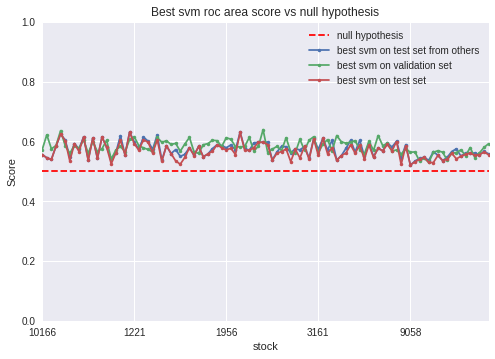

In [16]:
stocks = df_bests_by_val['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests_by_test['test_roc_auc_score'].plot(marker='.', label='best svm on test set from others')
df_bests_by_test['roc_auc_score'].plot(marker='.', label='best svm on validation set')
df_bests_by_val['test_roc_auc_score'].plot(marker='.', label='best svm on test set')
print('min: ', df_bests_by_test['test_roc_auc_score'].min(), 'max:',  
      df_bests_by_test['test_roc_auc_score'].max())
plt.ylabel('Score')
plt.legend()
plt.ylim(0, 1)
plt.title('Best svm roc area score vs null hypothesis')

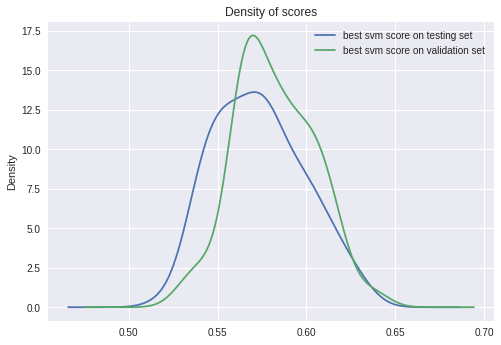

In [17]:
df_bests_by_test['test_roc_auc_score'].plot('kde', label='best svm score on testing set')
df_bests_by_test['roc_auc_score'].plot('kde', label='best svm score on validation set')
plt.title('Density of scores')
plt.legend()

In [18]:
df_counts = df_bests_by_test.groupby(['kernel'])[['kernel']].count()
df_counts_val = df_bests_by_val.groupby(['kernel'])[['kernel']].count()
df_counts.rename(columns={'kernel': 'kernel_test'}, inplace=True)
df_counts = df_counts.join(df_counts_val)

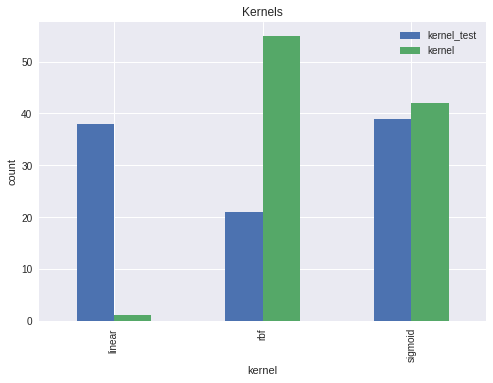

In [19]:
df_counts.plot(kind='bar')
plt.title('Kernels')
plt.ylabel('count')
plt.xlabel('kernel')

### SVM vs logistic regression

In [20]:
print('Number of better SVMs:', 
      len(df_bests_by_test[df_bests_by_test['test_log_roc_auc_score'] < 
                           df_bests_by_test['test_roc_auc_score']]['stock'].unique()), 
      'per', len(df_bests_by_test['stock'].unique()))

Number of better SVMs: 72 per 98


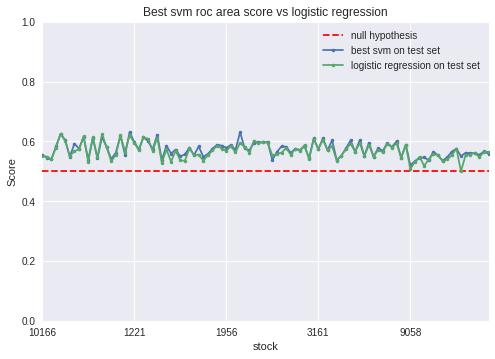

In [21]:
stocks = df_bests_by_test['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests_by_test['test_roc_auc_score'].plot(marker='.', label='best svm on test set')
df_bests_by_test['test_log_roc_auc_score'].plot(marker='.', label='logistic regression on test set')

plt.ylabel('Score')
plt.legend()
plt.ylim(0, 1)
plt.title('Best svm roc area score vs logistic regression')

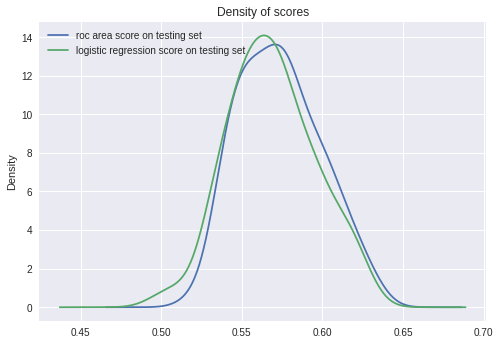

In [22]:
df_bests_by_test['test_roc_auc_score'].plot('kde', label='roc area score on testing set')
df_bests_by_test['test_log_roc_auc_score'].plot('kde', label='logistic regression score on testing set')
plt.title('Density of scores')
plt.legend()

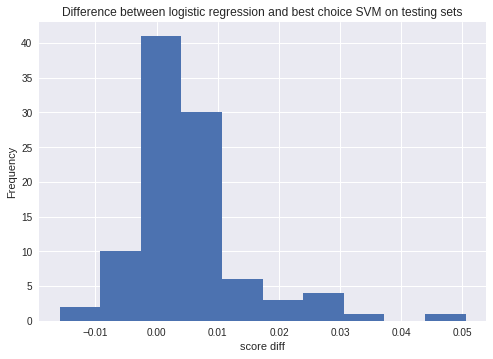

In [23]:
df_bests_by_test['diff'].plot(kind='hist')
plt.title('Difference between logistic regression and best choice SVM on testing sets')
plt.xlabel('score diff')

In [24]:
## Conclusions